It is currently the end of week five of Google Summer of Code 2023. According to the original deliverables table outlined in my proposal, the goal was to have opened a draft PR for the core functionality of the `plot_comparisons`. Subsequently, week six and seven were to be spent further developing the `plot_comparisons` function, and writing tests and a demo notebook for the documentation, respectively. However, in...

## Average Predictive Comparisons

`comparisons` and `plot_comparisons` are a part of Bambi's sub-package `plots` that feature a set of functions used to interpret complex regression models. This sub-package is inspired by the R package [marginaleffects](https://vincentarelbundock.github.io/marginaleffects/articles/predictions.html#conditional-adjusted-predictions-plot). These two functions allow the modeler to **compare** the predictions made by a model for different contrasts and covariate values.

Due to the link function in a GLM, there are typically three quantities of interest to interpret:
1. the linear predictor $\eta = X\beta$ where $X$ is an $n$ x $p$ matrix of explanatory variables.
2. the mean $\mu = g^{-1}(\eta)$ where the link function $g(\cdot)$ relates the linear predictor to the mean of the outcome variable $\mu = g^{-1}(\eta) = g^{-1}(X\beta)$
3. the response variable $Y \sim \mathcal{D}(\mu, \theta)$ where $\mu$ is the mean parameter and $\theta$ is (possibly) a vector that contains all the other "nuissance" parameters of the distribution.
 
With GLMs, $\eta$ is linear in the parameters, but non-linear in relation to the outputs $Y$ due to the link function $g$. Thus, as modelers, we are usually more interested in interpreting (2) and (3). For example, in logistic regression, the linear predictor is on the log-odds scale, but the response variable is on the probability scale. In Poisson regression, the linear predictor is on the log-scale, but the response variable is on the count scale. Referring back to logistic regression, a specified difference in one of the $x$ variables does _not_ correspond to a constant difference in the the probability of the outcome.

It is often helpful with GLMs, to the modeler and audience, to have a summary that gives the expected difference in the outcome corresponding to a unit difference in each of the input variables. Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predicted comparisons.

### Methodology

Here, I adopt the notation from Chapter 14.4 of [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) to describe average predicted comparisons. 

Assume we have fit a Bambi model predicting an outcome $Y$ based on inputs $X$ and parameters $\theta$. Consider the following scalar inputs:

$$u: \text{the input of interest}$$
$$v: \text{all the other inputs}$$
$$X = (u, v)$$

Suppose for the input of interest, we are interested in comparing $u = u^{\text{hi}}$ to $u = u^{\text{low}}$ with all other inputs $v$ held constant. The _predictive difference_ in the outcome changing **only** $u$ from is:

$$\text{predictive difference (comparison)} = \mathbb{E}(y|u^{\text{hi}}, v, \theta) - \mathbb{E}(y|u^{\text{lo}}, v, \theta)$$

Selecting the maximum and minimum values of $u$ and averaging over all other inputs $v$ in the data gives you a new "hypothetical" dataset and corresponds to counting all pairs of transitions of $(u^\text{lo})$ to $(u^\text{hi})$, i.e., differences in $u$ with $v$ held constant. 

### Implementation

To demonstrase how to compute and plot _average predictive comparisons_ with `comparisons` and `plot_comparions`, we model and predict how many fish are caught by visitors to a state park. Many visitors catch zero fish, either because they did not fish at all, or because they were unlucky. We would like to explicitly model this bimodal behavior (zero versus non-zero) using a Zero Inflated Poisson model, and to compare how different inputs of interest $u$ and other covariate values $v$ are associated with the number of fish caught.

In [15]:
#| code-fold: true
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison, comparisons

In [4]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["livebait"] = fish_data["livebait"].astype("category")
fish_data["camper"] = fish_data["camper"].astype("category")

In [6]:
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zip", likelihood, links)
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}

In [7]:
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    priors=priors,
    family=zip_family
)

fish_idata = fish_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In both `plot_comparisons` and `comparisons`, $u$ and $v$ are represented by `contrast` and `conditional`, respectively. Lets say we are interested in comparing the number of fish caught for `livebait` = [0, 1] conditional on the number of people.

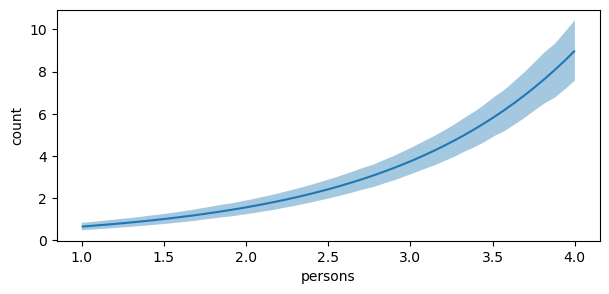

In [10]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
) 
fig.set_size_inches(7, 3)

By default, `contrast` compares $u^\text{hi}$ to $u^\text{lo}$. Thus, in this example `livebait` = 1 and `livebait` = 0. The plot shows us that comparing a group of two people who used live bait and no live bait, the expected difference in the number of fish caught is about $2$. As the number of people in the group increases, the expected difference also increases. 

We can call `comparisons` directly to view a summary dataframe that includes the term $u$ and its contrast, the specified `conditional` covariate, and the expected difference in the outcome with the uncertainty interval (in this case the 94% highest density interval). We see that `camper` and `child` are also in the summary dataframe. This is because for unspecified covariates, `comparisons` and `plot_comparisons` computes a default value. Thus, $v$ = `persons`, `camper`, `child`.

In [17]:
comparisons_df = comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
)
comparisons_df.head(10)

,term,contrast,persons,camper,child,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",1.000000,1.0,0.684,0.656590,0.483500,0.833816
1,livebait,"(0.0, 1.0)",1.061224,1.0,0.684,0.692487,0.509677,0.873858
2,livebait,"(0.0, 1.0)",1.122449,1.0,0.684,0.730352,0.545617,0.924122
3,livebait,"(0.0, 1.0)",1.183674,1.0,0.684,0.770294,0.578521,0.971953
4,livebait,"(0.0, 1.0)",1.244898,1.0,0.684,0.812425,0.616945,1.024377
5,livebait,"(0.0, 1.0)",1.306122,1.0,0.684,0.856867,0.647213,1.069846
6,livebait,"(0.0, 1.0)",1.367347,1.0,0.684,0.903747,0.687662,1.127065
7,livebait,"(0.0, 1.0)",1.428571,1.0,0.684,0.953198,0.730820,1.186828
8,livebait,"(0.0, 1.0)",1.489796,1.0,0.684,1.005363,0.770465,1.244912
9,livebait,"(0.0, 1.0)",1.551020,1.0,0.684,1.060390,0.813576,1.306117


Furthermore, `conditional` is not limited to one covariate. We can pass a list of covariates to condition on. For example, we can also include `camper`.

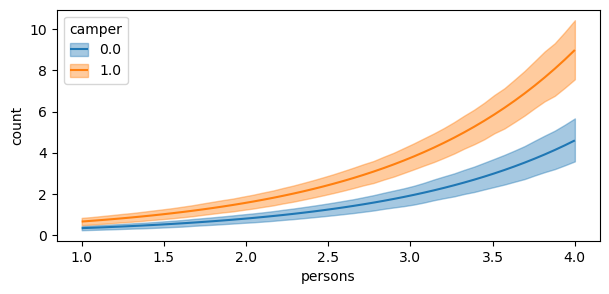

In [11]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "camper"],
) 
fig.set_size_inches(7, 3)